# Download and review the data at the link below:
https://www.kaggle.com/c/ultrasound-nerve-segmentation/data

# Import of different libraries

In [ ]:
# example of installing the additional required libraries

# !pip install tifffile 
# !pip install imagecodecs 

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import shutil

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations
import torchvision 
from torchvision import transforms, models, utils

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import random
from skimage import io,transform
from PIL import Image

from sklearn import model_selection

import time
from tqdm import tqdm

import warnings 

warnings.filterwarnings("ignore")

In [ ]:
#set device config: using either GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset preprocessing

In [ ]:
# create a dataframe of references and paths

ROOT = "./ultrasound-nerve-segmentation/"
trainpath = "./ultrasound-nerve-segmentation/train/"
testpath = "./ultrasound-nerve-segmentation/test/"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]

df = pd.DataFrame({"Image":imgs,"Mask":masks})

In [ ]:
#  ensure it works by showing the example 3 lines
df.head(3)

In [ ]:
# plot 3 by 3 images from the dataset with the masks overlay

rows,cols=3,3
fig=plt.figure(figsize=(16,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df))
    fig.add_subplot(rows,cols,i)
    img_path=df['Image'][ii]
    msk_path=df['Mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
plt.show()

In [ ]:
# make folds

def makesplits(df,k):
    df["kfold"] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    kf = model_selection.KFold(n_splits=k)

    for f,(t_,v_) in enumerate(kf.split(df)):
        df.loc[v_,"kfold"] = f
    return df

In [ ]:
# save the folds to the file for the further loading to reproduce the given split
kfold_ = makesplits(df,5)
kfold_.to_csv("Kfolds.csv",index=None)

In [ ]:
#  define some basic augmentations to the training data
def trainaugs():
    transform =  [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip()
            ]
    return albumentations.Compose(transform) # useful lib

def valaugs():
    transform = [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip()
            ]
    return albumentations.Compose(transform)

In [ ]:
# dataloader, returns image and mask
class NerveDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = self.imagespath[idx]
        mask = self.maskspath[idx]
        image = io.imread(image)
        mask = io.imread(mask)
        image = transform.resize(image=image,output_shape=(256,256,3)) # (256,256,3)
        image = image/255.0
        mask = transform.resize(mask,(256,256))  # (256,256,1)
        mask = mask / 255.0
        
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
            
        image = image.transpose((2, 0, 1)) # (3,256,256)
        mask = np.expand_dims(mask,axis=-1).transpose((2,0,1)) # (1,256,256)
            
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
            
        return image,mask

# Create neural network 

In [ ]:
# here we define the convolution network, the classical U-Net implementation
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
#  Encoder        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
#  Decoder       
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x
        
#  U-Net       
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out

# Metrics and Losses

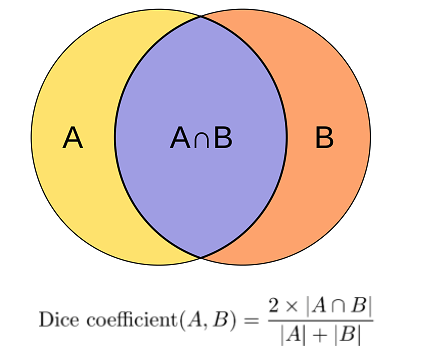

In [ ]:
# Here we define the loss and the metric for the segmentation task:
#  Loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return dice_loss

    
#   Score  
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

# Defining the training process function  

In [ ]:
# Let's now train our model
def trainfold(fold):
    train_loss = []
    train_dice = []
    val_loss = []
    val_dice = []
    epochs = 2
    train_bs= 8
    val_bs = 4
    
    FILE = f"./savedmodels/model_Fold_{fold}.pth"
    
    if not os.path.exists("./savedmodels"):
        os.mkdir("savedmodels")
        
    print(f"*"*20,"FOLD",fold, "*"*20)
    df = pd.read_csv("Kfolds.csv")
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_val = df[df.kfold == fold].reset_index(drop=True)
    
    traindata = NerveDataset(imagespath = df_train['Image'].tolist(),
                            maskspath = df_train['Mask'].tolist(),
                        augment=trainaugs())

    validationdata = NerveDataset(imagespath = df_val['Image'].tolist(),
                                maskspath = df_val['Mask'].tolist(),augment=valaugs())

    trainloader = DataLoader(traindata,batch_size = train_bs,shuffle=True)
    valloader = DataLoader(validationdata,batch_size=val_bs,shuffle=False)
    
    model = Unet256((3,256,256)).to(device)
    criterion = DiceLoss() # here we use the aforementioned Loss function
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # use a standard approach with the Adam optimizer with the given learning rate
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        start_time = time.time()
        running_train_loss = []

        tk_train = tqdm(trainloader,total = len(trainloader))
        for image,mask in tk_train: 
                image = image.to(device,dtype=torch.float)
                mask = mask.to(device,dtype=torch.float)

                pred_mask = model.forward(image) # forward propogation
                loss = criterion(pred_mask,mask)
                optimizer.zero_grad() # setting gradient to zero
                loss.backward()
                optimizer.step() # the step of the optimizer
                running_train_loss.append(loss.item())
        else:           
            running_val_loss = [] # validation loss
            
            with torch.no_grad():
                tk_val = tqdm(valloader,total = len(valloader))
                for image,mask in tk_val:
                        image = image.to(device,dtype=torch.float)
                        mask = mask.to(device,dtype=torch.float)                            
                        pred_mask = model.forward(image)
                        loss = criterion(pred_mask,mask)
                        running_val_loss.append(loss.item())

        epoch_train_loss = np.mean(running_train_loss) 
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Train DiceLoss: {epoch_train_loss}')                       
        train_loss.append(epoch_train_loss)
        
        epoch_val_loss = np.mean(running_val_loss)
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Validation DiceLoss: {epoch_val_loss}')                                
        val_loss.append(epoch_val_loss)
        

        time_elapsed = time.time() - start_time
        print('Fold {}: Time Taken: {:.0f}m {:.0f}s'.format(fold,time_elapsed // 60, time_elapsed % 60))
        
    torch.save(model.state_dict(), FILE)
        
    return train_loss, val_loss

# Let's train:

In [ ]:
train_loss, val_loss = trainfold(0)